# Preamble

Theodore Barnhart | tbarnhart@usgs.gov | theodore.barnhart@colorado.edu | April 6, 2019

This notebook explores global parameter sensivitivty using the dela-moment method (Plischke et al., 2013).

This is done via three analyses on two datasets, making six sensitivity analysese:

**Analysis 1:**
SA is run on outputs with only optimized rooting depth (combo == 6)

**Analysis 2:**
SA is run on outputs with all rooting depths to assess the importance of plant available water storage (PAWS).

**Analysis 3:**
SA is run on outputs with all rooting depths and sites.

**Dataset 1:**
Ablation season runoff ratio (abblRR_ET)

**Dataset 2:**
Ablation season change in subsurface storage (wb)

In [78]:
import pandas as pd
from SALib.analyze import delta
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

## Load Data

In [2]:
# load data
site = 'Nr1'
exname = 'smex8_sen'
method = '8'
period = 'melt'
Nr1 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df') # load the first experiment
Nr1['site'] = 'Nr1'

site = 'p301'
exname = 'smex8_sen'
method = '8'
period = 'melt'
P301 = pd.read_hdf('./data/%s_%s_%s_processed_for_SA.h5'%(site,exname,period),'df')
P301['site'] = 'P301'

In [3]:
# clean the data to remove scenarios where ET is greater than snowmelt
Nr1 = Nr1.loc[Nr1.ablRR_ET>0]
P301 = P301.loc[P301.ablRR_ET>0]

In [5]:
dat = pd.concat([Nr1,P301])

In [6]:
# define problem
problem1 = {
    'num_vars': 2,
    'names': ['SMR', 'TpeakSWE'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

problem2 = {
    'num_vars': 3,
    'names': ['SMR', 'TpeakSWE','rd'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

problem3 = {
    'num_vars': 4,
    'names': ['SMR', 'TpeakSWE', 'rd','site'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]}

In [9]:
resamp = 25
console = False

Yvars = []
Sites = []
outputs = []
Problems = []
for Yvar in ['ablRR_ET','wb']:
    for problem in [problem1,problem2,problem3]:
        for site in ['Nr1','P301','All']:
            if site != 'All': # if a specific site is requested
                if problem['num_vars'] > 2: # use all the rooting depths
                    Y = dat.loc[(dat.site == site),Yvar].values
                    X = dat.loc[(dat.site == site),problem['names']].values
                else: # if the analysis includes only two variables, use optimal PAWS
                    Y = dat.loc[(dat.site == site) & (dat.combo == 6),Yvar].values
                    X = dat.loc[(dat.site == site) & (dat.combo == 6),problem['names']].values
            else: # otherwise use all the sites
                Y = dat[Yvar].values
                X = dat[problem['names']].values
                
            Yvars.append(Yvar)
            Sites.append(site)
            outputs.append(delta.analyze(problem, X, Y, print_to_console=console, num_resamples=resamp))
            Problems.append(problem)

Parameter delta delta_conf S1 S1_conf
SMR 0.183905 0.007927 0.234695 0.018625
TpeakSWE 0.300084 0.006470 0.514652 0.013580
Parameter delta delta_conf S1 S1_conf
SMR 0.319906 0.009045 0.569431 0.018744
TpeakSWE 0.137338 0.007507 0.097525 0.011743
Parameter delta delta_conf S1 S1_conf
SMR 0.203888 0.001899 0.240872 0.003017
TpeakSWE 0.158233 0.001188 0.151007 0.002965
Parameter delta delta_conf S1 S1_conf
SMR 0.189633 0.001591 0.141974 0.003237
TpeakSWE 0.254288 0.001902 0.310058 0.004316
rd 0.276609 0.001170 0.184382 0.001997
Parameter delta delta_conf S1 S1_conf
SMR 0.247360 0.002072 0.403615 0.005502
TpeakSWE 0.168720 0.002221 0.077521 0.002245
rd 0.229779 0.003010 0.192470 0.002291
Parameter delta delta_conf S1 S1_conf
SMR 0.203784 0.001192 0.240872 0.003168
TpeakSWE 0.158277 0.001241 0.151007 0.002604
rd 0.277985 0.001481 0.188195 0.001479
Parameter delta delta_conf S1 S1_conf
SMR 0.189490 0.001617 0.141974 0.002628
TpeakSWE 0.255124 0.002380 0.310058 0.004746
rd 0.276590 0.001636 0

In [13]:
# process the results
dfs = []

for Yvar,site,output,problem in zip(Yvars,Sites,outputs,Problems):
    df = pd.DataFrame()
    
    df['delta'] = output['delta']
    df['error'] = output['delta_conf']
    df['parameter'] = problem['names']
    df['variable'] = Yvar
    df['site'] = site
    df['problem'] = len(problem['names']) - 1
    
    dfs.append(df)
    
df = pd.concat(dfs)

In [22]:
def param2num(param):
    if param == 'SMR':
        return 1
    if param == 'TpeakSWE':
        return 2
    if param == 'rd':
        return 3
    if param == 'site':
        return 4

In [23]:
df['paramNum'] = df.parameter.map(param2num)

In [24]:
df.to_pickle('./data/si_analysis.pcl')

In [25]:
df.head()

,delta,error,parameter,variable,site,problem,paramNum
0,0.183905,0.007927,SMR,ablRR_ET,Nr1,1,1
1,0.300084,0.006470,TpeakSWE,ablRR_ET,Nr1,1,2
0,0.319906,0.009045,SMR,ablRR_ET,P301,1,1
1,0.137338,0.007507,TpeakSWE,ablRR_ET,P301,1,2
0,0.203888,0.001899,SMR,ablRR_ET,All,1,1


# Plotting

Make one two pannel plot with runoff on the left and change in subsurface storage on the right

Colors == different SA problems

Symbols == different sites

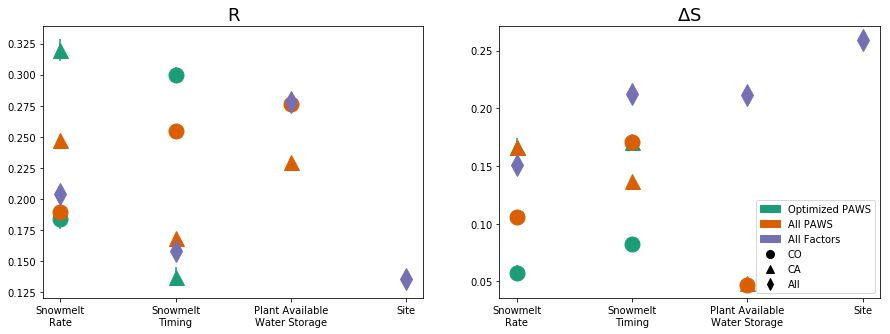

In [92]:
tmps = []
titleFont = 18
markerSize = 15
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage','Site']
xticks = np.arange(1,len(xlabels)+1)

problems = [1,2,3]
colors = ['#1b9e77','#d95f02','#7570b3']
sites = ['Nr1','P301','All']
siteLabels = ['CO','CA','All']
siteSymbs = ['o','^','d']
titles = ['R','$\Delta$S']
variables = ['ablRR_ET','wb']

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

axs = [ax1,ax2]
for ax,title,var in zip(axs,titles,variables):
    plt.sca(ax)
    plt.title(title, fontsize = titleFont)

    for problem,color in zip(problems,colors):
        #sites = df.loc[(df.problem == problem) & (df.variable == var)].site.unique()
        if problem < 3:
            sites = ['Nr1','P301']
        else:
            sites = ['All']
        for i,site in enumerate(sites):
            label = siteLabels[i]
            symb = siteSymbs[i]

            if len(sites) == 1:
                label = siteLabels[2]
                symb = siteSymbs[2]

            tmp = df.loc[(df.problem == problem) & (df.site == site) & (df.variable == var)]

            ax.errorbar(tmp.paramNum, tmp.delta, yerr=tmp.error, fmt=symb, color = color, label = label,
                         markersize = markerSize)
            tmps.append(tmp)

        plt.xticks(ticks = xticks, labels = xlabels)

# do the legend
custom_lines = [Patch(facecolor=colors[0], edgecolor=colors[0],label='Optimized PAWS'),
                Patch(facecolor=colors[1], edgecolor=colors[1],label='All PAWS'),
                Patch(facecolor=colors[2], edgecolor=colors[2],label='All Factors'),
                Line2D([0], [0], color='k', marker=siteSymbs[0], lw=0, markersize=8,label = 'CO'),
                Line2D([0], [0], color='k', marker=siteSymbs[1], lw=0, markersize=8, label = 'CA'),
                Line2D([0], [0], color='k', marker=siteSymbs[2], lw=0, markersize=8, label = 'All')]
                       
plt.legend(handles=custom_lines);

# Little confusing, break in to 6 panels:

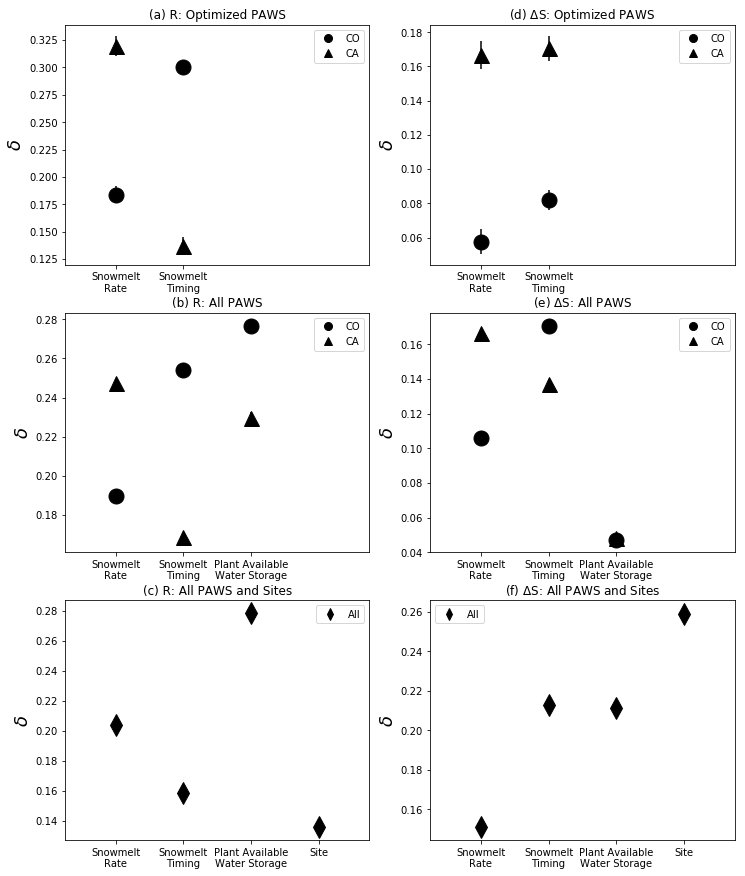

In [129]:
tmps = []
titleFont = 18
markerSize = 15
xlabels = ['Snowmelt\nRate', 'Snowmelt\nTiming','Plant Available\nWater Storage','Site']
xticks = np.arange(1,len(xlabels)+1)

titles2 = ['Optimized PAWS','All PAWS','All PAWS and Sites']

problems = [1,2,3]
colors = ['#1b9e77','#d95f02','#7570b3']
sites = ['Nr1','P301','All']
siteLabels = ['CO','CA','All']
siteSymbs = ['o','^','d']
titles = ['R','$\Delta$S']
variables = ['ablRR_ET','wb']

fig = plt.figure(figsize=(12,15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)

# do the legend
custom_lines = [Line2D([0], [0], color='k', marker=siteSymbs[0], lw=0, markersize=8,label = 'CO'),
                Line2D([0], [0], color='k', marker=siteSymbs[1], lw=0, markersize=8, label = 'CA'),
                Line2D([0], [0], color='k', marker=siteSymbs[2], lw=0, markersize=8, label = 'All')]

axes = [[ax1,ax3,ax5],[ax2,ax4,ax6]] 

for axs,title,var in zip(axes,titles,variables):
    for ax,problem in zip(axs,problems):
        plt.sca(ax)
        plt.title(title, fontsize = titleFont)
        #sites = df.loc[(df.problem == problem) & (df.variable == var)].site.unique()
        if problem < 3:
            sites = ['Nr1','P301']
        else:
            sites = ['All']
        for i,site in enumerate(sites):
            label = siteLabels[i]
            symb = siteSymbs[i]

            if len(sites) == 1:
                label = siteLabels[2]
                symb = siteSymbs[2]

            tmp = df.loc[(df.problem == problem) & (df.site == site) & (df.variable == var)]

            ax.errorbar(tmp.paramNum, tmp.delta, yerr=tmp.error, fmt=symb, color = 'k', label = label,
                         markersize = markerSize)
            tmps.append(tmp)
            plt.xlim(0.25,4.75)
            plt.xticks(ticks = xticks[0:problem+1], labels = xlabels[0:problem+1])
            
            l = len(sites)
            if l == 1:
                plt.legend(handles=[custom_lines[2]]);
            else:
                plt.legend(handles=custom_lines[0:l]);
            
for ax,title,lab in zip([ax1,ax3,ax5],titles2, ['(a)','(b)','(c)']):
    ax.set_ylabel('$\delta$', fontsize = 18)
    ax.set_title('%s R: %s'%(lab,title))
    
for ax,title,lab in zip([ax2,ax4,ax6],titles2,['(d)','(e)','(f)']):
    ax.set_ylabel('$\delta$', fontsize = 18)
    ax.set_title('%s $\Delta$S: %s'%(lab,title))